In [1]:
from firedrake import *
from pyroteus_adjoint import *
from icepack import compute_surface
from icepack.models import IceStream
from icepack.solvers import FlowSolver
from icepack.constants import (
    ice_density as rho_I,
    water_density as rho_W,
    gravity as g,
    weertman_sliding_law as m,
)
from glac_adapt.adapt import mismip_bed_topography, friction_law
from glac_adapt.options import Options
from tqdm import trange


def get_function_spaces(mesh):
    """
    Get the finite element space for a given mesh.
    """
    return {"u": VectorFunctionSpace(mesh, "CG", 2)}


def get_solver(mesh_seq):
    options = mesh_seq.options

    def solver(index, ic):
        """
        Solve forward over time window (`t_start`, `t_end`).
        """
        t_start, t_end = mesh_seq.time_partition.subintervals[index]
        msh = ic.u.function_space().mesh()
        fspace = ic.u.function_space()

        Q = FunctionSpace(msh, "CG", fspace._ufl_element.degree())

        # accumulation = Function(Q, name='accumulation')
        u_ = Function(fspace, name="u_old")
        u = Function(fspace, name="u")

        u_.assign(ic["u"])
        mesh_seq.h = interpolate(Constant(100), Q)

        u.assign(u_)
        mesh_seq.z_b = interpolate(mismip_bed_topography(msh, 80e3), Q) # TODO: Ly
        mesh_seq.s = compute_surface(thickness=mesh_seq.h, bed=mesh_seq.z_b)

        mesh_seq.icepack_model = IceStream(friction=friction_law)
        mesh_seq.icepack_solver = FlowSolver(
            mesh_seq.icepack_model, **options.domain, **options.solvers)

        h_0 = mesh_seq.h.copy(deepcopy=True)
        num_steps = int((t_end - t_start) / mesh_seq.options.simulation.timestep)
        progress_bar = trange(num_steps)

        for i, _ in enumerate(progress_bar):

            mesh_seq.h = mesh_seq.icepack_solver.prognostic_solve(
                options.timestep,
                thickness=mesh_seq.h,
                velocity=u,
                accumulation=options.constants.acc_rate, #accumulation,
                thickness_inflow=h_0
            )
            # mesh_seq.h.interpolate(max_value(mesh_seq.h, 1.0))
            mesh_seq.s = compute_surface(thickness=mesh_seq.h, bed=mesh_seq.z_b)

            u = mesh_seq.icepack_solver.diagnostic_solve(
                velocity=u,
                thickness=mesh_seq.h,
                surface=mesh_seq.s,
                fluidity=options.constants.viscosity,
                friction=options.constants.friction
            )

            # if i % options.simulation_export_idx == 0:
            #     with CheckpointFile(f"{options.simulation.output}/{output}", 'a') as afile:
            #         afile.save_function(
            #             u, 
            #             idx=int(i/options.simulation_export_idx), 
            #             name="velocity"
            #             )
            #         afile.save_function(
            #             mesh_seq.h, 
            #             idx=int(i/options.simulation_export_idx), 
            #             name="thickness"
            #         )

            # min_h = mesh_seq.h.dat.data_ro.min()
            # max_h = mesh_seq.h.dat.data_ro.max()
            volume = assemble(mesh_seq.h * dx)
            # avg_h = assemble(mesh_seq.h * dx) / (options.domain.Lx * options.domain.Ly)
            progress_bar.set_description(f"volume: {volume / (1e9 * 917):4.2f} GT we")

            # qoi = mesh_seq.get_qoi(i)

        return {"u": u}
    return solver


def get_initial_condition(mesh_seq):
    V = mesh_seq.function_spaces["u"][0]
    x = SpatialCoordinate(mesh_seq[0])[0]
    u = interpolate(as_vector((90 * x / mesh_seq.options.domain.Lx, 0)), V)

    return {'u': u}


def get_form(mesh_seq):
    def form(index, sols):
        u, u_ = sols["u"]

        action = mesh_seq.icepack_solver._diagnostic_solver._model.action(
            velocity=u,
            thickness=mesh_seq.h,
            surface=mesh_seq.s,
            fluidity=mesh_seq.options.constants.viscosity,
            friction=mesh_seq.options.constants.friction,
            **mesh_seq.options.domain
        )

        F = derivative(action, u)

        return F
    return form


def get_bcs(mesh_seq):
    def bcs(index):
        V = mesh_seq.function_spaces["u"][index]

        if hasattr(V._ufl_element, "_sub_element"):
            bc = DirichletBC(V, Constant((0, 0)), mesh_seq.options.domain.dirichlet_ids)
        else:
            bc = DirichletBC(V, Constant(0), mesh_seq.options.domain.dirichlet_ids)
        if not mesh_seq.options.domain.dirichlet_ids:
            bc = None

        return bc
    return bcs

firedrake:WARNING OMP_NUM_THREADS is not set or is set to a value greater than 1, we suggest setting OMP_NUM_THREADS=1 to improve performance


In [2]:
from glac_adapt.meshadapt import adapt

def adaptor(mesh_seq, sols):
    sol_u = sols['u']['forward'][0][-1]
    # err_ind = inds[-1][-1]

    Q = FunctionSpace(mesh_seq[0], family='CG', degree=1)
    ux = Function(Q)
    ux.interpolate(sol_u[0])
    uy = Function(Q)
    uy.interpolate(sol_u[1])
    hessianx = recover_hessian(ux)
    # hessiany = recover_hessian(uy)
    hmetricx = hessian_metric(hessianx)
    # hmetricy = hessian_metric(hessiany)

    # int_metric = metric_intersection(hmetricx, hmetricy)
    # final_metric = isotropic_metric(err_ind)
    final_metric = hmetricx

    metcom = metric_complexity(final_metric)#hmetricx)
    Nvert = 3000
    d = 2
    alpha = (Nvert / metcom) ** (2/d)

    # hmetricx.assign(alpha*hmetricx)
    final_metric.assign(alpha*final_metric)

    old_mesh = mesh_seq.meshes[0]
    adapted_mesh = adapt(old_mesh, final_metric)
    print('old, new num_vertices: ', old_mesh.num_vertices(), adapted_mesh.num_vertices())

    meshes.append(adapted_mesh)

    mesh_seq.meshes = [adapted_mesh]

In [3]:
half = True
resolution = 5000 #args.resolution
input_idx = 0 #args.input_idx
timesteps_per_export = 1 #args.timesteps_per_export
simulation_end_time = 6000.0  #args.simulation_end_time
simulation_timestep = 5.0  #args.simulation_timestep


Ly = 40e3 if half else 80e3
opts = {
    "timestep": simulation_timestep, 
    "end_time": simulation_end_time, 
    "Ly": Ly,
    # "output": output_dir, 
    "simulation_export_idx": timesteps_per_export,
    # "input": input_dir,
    # "simulation_export_time": args.simulation_export_time,
}
options = Options(**opts)

nx = int(options.domain.Lx / resolution)
ny = int(options.domain.Ly / options.domain.Lx * nx)
print('nx =', nx, 'ny =', ny)

mesh = RectangleMesh(nx, ny, options.domain.Lx, options.domain.Ly, name="mesh_0")
options.initial_mesh = mesh

nx = 128 ny = 8


In [4]:
meshes = [options.initial_mesh]

fields = ["u"]
num_subintervals=1
meshes = [options.initial_mesh]
time_partition = TimePartition(
    options.simulation.end_time,
    num_subintervals,
    options.simulation.timestep,
    fields,
    timesteps_per_export=200,  # timesteps_per_export,
)

msq = MeshSeq(
    time_partition,
    meshes,
    get_function_spaces=get_function_spaces,
    get_initial_condition=get_initial_condition,
    get_form=get_form,
    get_bcs=get_bcs,
    get_solver=get_solver,
)
msq.options = options

solutions = msq.solve_forward()
# msq.fixed_point_iteration(adaptor)

volume: 5.39 GT we:   6%|▌         | 67/1200 [01:07<19:08,  1.01s/it] 


KeyboardInterrupt: 

In [6]:
sol_u = solutions.u.forward[-1][-1]
sol_h = msq.h
sol_s = msq.s

Text(0.5, 1.0, 's')

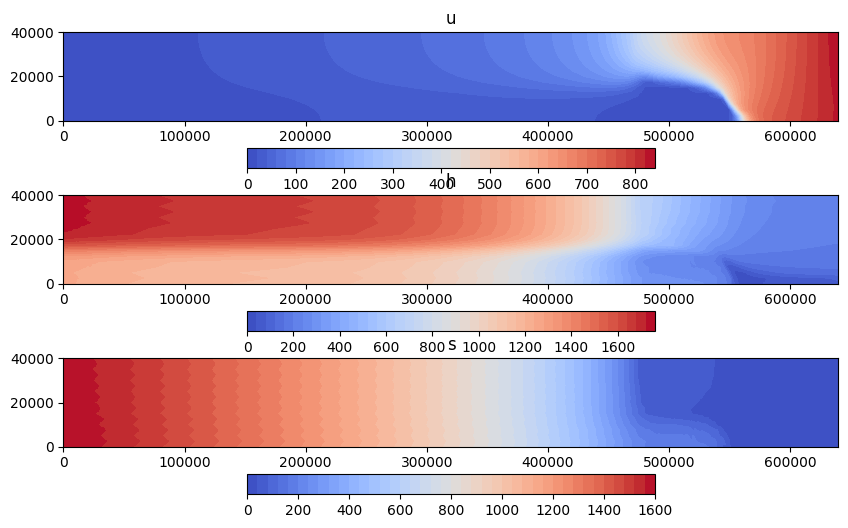

In [7]:
import matplotlib.colors as mcolors
from matplotlib import ticker
import matplotlib.pyplot as plt

plot_kwargs = {"levels": 50, "cmap": "coolwarm"}
fig, axes = plt.subplots(3, 1, figsize=(10, 6))
im = tricontourf(sol_u, axes=axes[0], **plot_kwargs)
fig.colorbar(im, orientation="horizontal", pad=0.2)
axes[0].set_title("u")

im = tricontourf(sol_h, axes=axes[1], **plot_kwargs)
fig.colorbar(im, orientation="horizontal", pad=0.2)
axes[1].set_title("h")

im = tricontourf(sol_s, axes=axes[2], **plot_kwargs)
fig.colorbar(im, orientation="horizontal", pad=0.2)
axes[2].set_title("s")

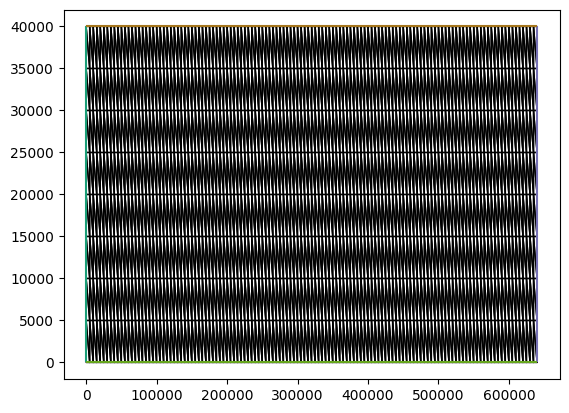

In [8]:
triplot(msq.options.initial_mesh)

In [9]:
Q = FunctionSpace(mesh, family='CG', degree=1)
ux = Function(Q)
ux.interpolate(sol_u[0])
uy = Function(Q)
uy.interpolate(sol_u[1])
ux_hess = recover_hessian(ux)
uy_hess = recover_hessian(uy)
ux_hess_met = hessian_metric(ux_hess)
uy_hess_met = hessian_metric(uy_hess)

h_hess = recover_hessian(sol_h)
h_hess_met = hessian_metric(h_hess)

s_hess = recover_hessian(sol_s)
s_hess_met = hessian_metric(s_hess)


In [12]:
adapted_mesh_ux = adapt(mesh, ux_hess_met)
print(adapted_mesh_ux.num_vertices())

adapted_mesh_h = adapt(mesh, h_hess_met)
print(adapted_mesh_h.num_vertices())

adapted_mesh_s = adapt(mesh, s_hess_met)
print(adapted_mesh_s.num_vertices())

3966
7647
2465


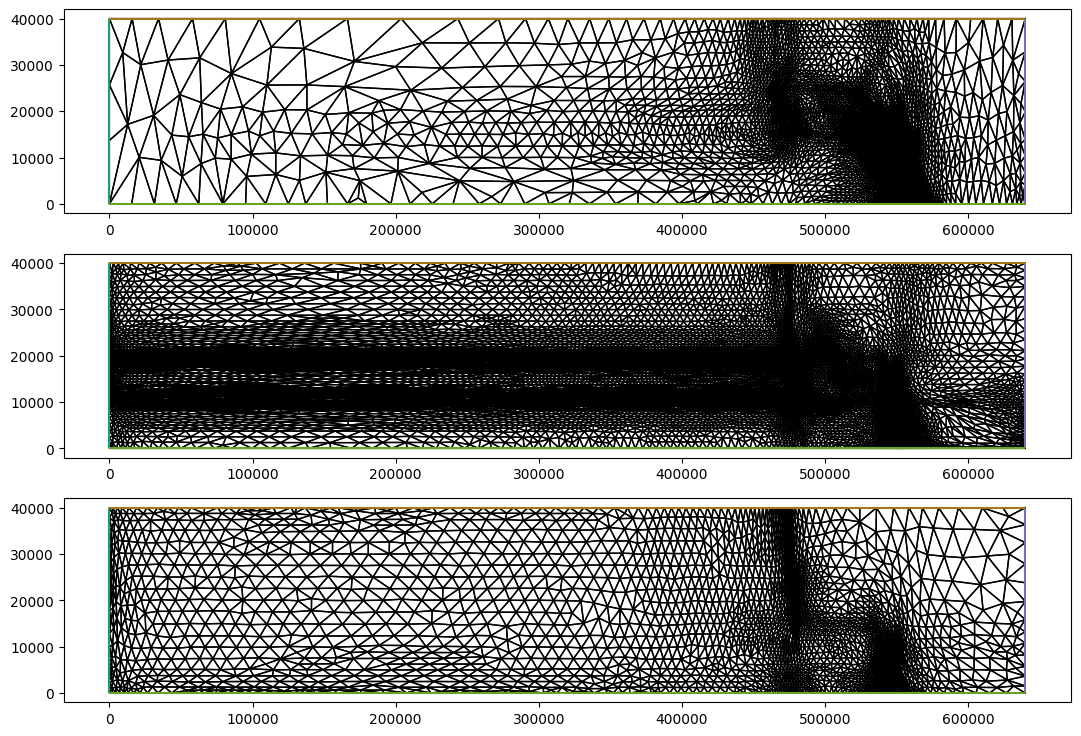

In [13]:
fig, axes = plt.subplots(3, 1, figsize=(13, 9))
triplot(adapted_mesh_ux, axes=axes[0])
triplot(adapted_mesh_h, axes=axes[1])
triplot(adapted_mesh_s, axes=axes[2])
